##  **Fine Tune LLAMA 2 With Custom Dataset Using LoRA And QLoRA Techniques**

Installing Dependencies
1. accelerate: Optimizes model training across various hardware setups, enabling multi-GPU and mixed-precision training.
2. peft: Simplifies parameter-efficient fine-tuning of large language models.
3. bitsandbytes: Provides 8-bit optimizers and memory-efficient training for large models.
4. transformers: A library for state-of-the-art Natural Language Processing (NLP) with pre-trained models like BERT, GPT, and others.
5. trl: Supports training and inference of transformer models with reinforcement learning techniques like Proximal Policy Optimization (PPO).

In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 transformers==4.31.0 trl==0.4.7

In [2]:
!pip install bitsandbytes==0.39.0

  Attempting uninstall: bitsandbytes
    Found existing installation: bitsandbytes 0.44.0
    Uninstalling bitsandbytes-0.44.0:
      Successfully uninstalled bitsandbytes-0.44.0


In [6]:
!python -m bitsandbytes



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++ BUG REPORT INFORMATION ++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++ OTHER +++++++++++++++++++++++++++
CUDA specs: CUDASpecs(highest_compute_capability=(7, 5), cuda_version_string='121', cuda_version_tuple=(12, 1))
PyTorch settings found: CUDA_VERSION=121, Highest Compute Capability: (7, 5).
To manually override the PyTorch CUDA version please see: https://github.com/TimDettmers/bitsandbytes/blob/main/docs/source/nonpytorchcuda.mdx
The directory listed in your path is found to be non-existent: /sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events
The directory listed in your path is found to be non-existent: //172.28.0.1
The directory listed in your path is found to be non-existent: 8013
The directory listed in your path is found to be non-existent: //colab.research.google.com/tun/m/cc48301118ce562b961b3c22d803539adc1e0c19/

In [3]:
!pip uninstall -y bitsandbytes


Found existing installation: bitsandbytes 0.39.0
Uninstalling bitsandbytes-0.39.0:
  Successfully uninstalled bitsandbytes-0.39.0


In [ ]:
!pip install bitsandbytes


In [7]:

#The transformers and bitsandbytes modules need to be reinstalled
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,

    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [22]:
import torch
torch.cuda.is_available()

True

In [25]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [8]:
from transformers import BitsAndBytesConfig

## **In case of Llama 2, the following prompt template is used for the chat models**
System Prompt (optional) to guide the model

User prompt (required) to give the instruction

Model Answer (required)

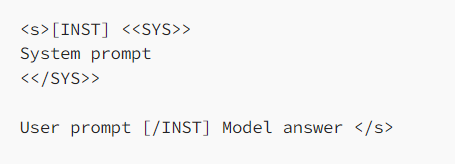

In [ ]:

from IPython.display import Image

# Display the image
Image(filename="/content/prompt.png")


In [9]:
from datasets import load_dataset

ds = load_dataset("timdettmers/openassistant-guanaco")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


In [11]:
ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 9846
    })
    test: Dataset({
        features: ['text'],
        num_rows: 518
    })
})

In [12]:

print(ds['train'][0])


{'text': '### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining po

## **We will reformat our instruction dataset to follow Llama 2 template.**

In [13]:
dataset = ds['train'].shuffle(seed=42).select(range(1000))
# it suffle the dataset completely then it will select 1000 rows from the dataset

In [14]:
dataset

Dataset({
    features: ['text'],
    num_rows: 1000
})

In [15]:
def transform_conversation(example):
    conversation_text = example['text']
    segments = conversation_text.split('###')
    reformatted_segments = []
    for i in range(1, len(segments) - 1, 2):
        human_text = segments[i].strip().replace('Human:', '').strip()

        # Check if there is a corresponding assistant segment before processing
        if i + 1 < len(segments):
            assistant_text = segments[i+1].strip().replace('Assistant:', '').strip()

            # Apply the new template
            reformatted_segments.append(f'<s>[INST] {human_text} [/INST] {assistant_text} </s>')
        else:
            # Handle the case where there is no corresponding assistant segment
            reformatted_segments.append(f'<s>[INST] {human_text} [/INST] </s>')

    return {'text': ''.join(reformatted_segments)}


# Apply the transformation
transformed_dataset = dataset.map(transform_conversation)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [16]:
transformed_dataset

Dataset({
    features: ['text'],
    num_rows: 1000
})

In [17]:
transformed_dataset[0]

{'text': '<s>[INST] Me gradué hace poco de la carrera de medicina ¿Me podrías aconsejar para conseguir rápidamente un puesto de trabajo? [/INST] Esto vale tanto para médicos como para cualquier otra profesión tras finalizar los estudios aniversarios y mi consejo sería preguntar a cuántas personas haya conocido mejor. En este caso, mi primera opción sería hablar con otros profesionales médicos, echar currículos en hospitales y cualquier centro de salud. En paralelo, trabajaría por mejorar mi marca personal como médico mediante un blog o formas digitales de comunicación como los vídeos. Y, para mejorar las posibilidades de encontrar trabajo, también participaría en congresos y encuentros para conseguir más contactos. Y, además de todo lo anterior, seguiría estudiando para presentarme a las oposiciones y ejercer la medicina en el sector público de mi país. </s>'}

#**Step 3**
1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune

QLoRA will use a rank of 64 with a scaling parametre of 16.We'll load the Llama 2 Model directly in 4 bit precision using the NFA4 type and train it for one epoch

In [25]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Step 4:Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [ ]:
# load dataset
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype =  getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use__4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)
#Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use__4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)


# load the base model
model =  AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)

model.config.use_cache = False
model.config.pretraining_tp = 1


# Load LlaMA tokenizer
tokenizer =  AutoTokenizer.from_pretrained(model_name , trust_remote_code =True)
tokenizer.pad_token =  tokenizer.eos_token
tokenizer.padding_side = "right"
#Load LoRA Configuaration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type:

Step,Training Loss
25,1.408000
50,1.664200
75,1.214500


In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

###**Step 6:Use the text generation pipeline to ask questions like “What is a large language model?” Note that I’m formatting the input to match Llama 2 prompt template.**

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "What is a large language model?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

#**Step 7: Store New Llama2 Model (Llama-2-7b-chat-finetune)**

How can we store our new Llama-2-7b-chat-finetune model now? We need to merge the weights from LoRA with the base model. Unfortunately, as far as I know, there is no straightforward way to do it: we need to reload the base model in FP16 precision and use the peft library to merge everything.

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

#**Step 8: Push Model to Hugging Face Hub**

Our weights are merged and we reloaded the tokenizer. We can now push everything to the Hugging Face Hub to save our model.

In [ ]:
!huggingface-cli login

model.push_to_hub("entbappy/Llama-2-7b-chat-finetune", check_pr=True)

tokenizer.push_to_hub("entbappy/Llama-2-7b-chat-finetune",check_pr=True) # nijer id te korbo